# Personality Predictor

Here's some interesting analysis that I don't think anyone else has ever done.

As a psychology professor, I give my students assignments that allow them to explore their personality and identity. As part of an assignment last year, I had students quantify their personality traits through a Google Doc form.

Then, in this notebook, I used natural language processing to uncover differences in the words people use. I had students write answers to 3 different prompts:

- How would you describe yourself if you were introducing yourself to a classmate? (I encouraged them to write as they normally talk, even if it included slang or swear words.)

- Complete the sentence "I am ______" 10 times.

- List 20 things you like. It can be anything -- movies, hobbies, food, people, etc.

For this notebook, I combined these prompts together. If I gather more data in subsequent semesters, I can get more granular in my analysis.

In [1]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation, digits

st = SnowballStemmer(language='english')

# Stopwords
other_stopwords = ['like', 'my', 'i', '•', "'s", 'nan', 'sometimes', 'well', '10',
                   '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']

# Functions
def text_process(text, stem=True):
    stopword_set = set(stopwords.words('english') + list(punctuation) +\
                        list(digits) + other_stopwords)
    
    # removes punctuation inside of words (e.g., hip-hop -> hip hop)
    for i in list(punctuation):
        text = text.replace(i, ' ')
    
    # Clean the words
    token = word_tokenize(text.lower())
    cleaned = [word for word in token if word not in stopword_set]
    
    # Stem the words (optional)
    if stem == True:
        cleaned = [st.stem(word) for word in cleaned]
    
    return cleaned

In [3]:
# Load data
data = pd.read_csv('personality_text.csv')

# Clean data & remove null rows
data = data[data.notnull().all(1)]

data['20_things_you_like'] = data['20_things_you_like'].astype(str)
data['your_introduction'] = data['your_introduction'].astype(str)
data['i_am'] = data['i_am'].astype(str)

# Big Five Personality Traits.
# Explained in more detail later, but you can
# get a feel for what they measure by looking
# at the questions.
#
# People rate how much they agree with each
# statement, from 1 to 7.

data['extraversion_score'] =\
(data.im_the_life_of_the_party +\
data.i_talk_to_a_lot_of_different_people_at_social_events +\
(8 - data.i_dont_talk_a_lot) +\
(8 - data.i_keep_in_the_background))/.28

data['openness_score'] =\
(data.i_have_a_vivid_imagination +\
(8 - data.i_have_difficulty_understanding_abstract_ideas) +\
(8 - data.i_dont_have_a_good_imagination) +\
(8 - data.im_not_interested_in_abstract_ideas) +\
(8 - data.i_do_not_like_art))/.35

data['agreeableness_score'] =\
(data.i_sympathize_with_others_feelings +\
data.i_feel_others_emotions +\
(8 - data.im_not_really_interested_in_others) +\
(8 - data.im_not_interested_in_peoples_problems))/.28

data['conscientiousness_score'] =\
(data.i_get_things_done_right_away +\
data.i_like_order +\
(8 - data.i_often_forget_to_put_things_back_in_their_proper_place) +\
(8 - data.i_ignore_my_responsibilities))/.28

data['neuroticism_score'] =\
(data.i_have_frequent_mood_swings +\
data.i_get_upset_easily +\
(8 - data.im_relaxed_most_of_the_time) +\
(8 - data.i_seldom_feel_blue))/.28

# Classifications
data['is_extravert'] = np.where(data.extraversion_score > data.extraversion_score.mean(), 1, 0)
data['is_open'] = np.where(data.openness_score > data.openness_score.mean(), 1, 0)
data['is_agreeable'] = np.where(data.agreeableness_score > data.agreeableness_score.mean(), 1, 0)
data['is_conscientious'] = np.where(data.conscientiousness_score > data.conscientiousness_score.mean(), 1, 0)
data['is_neurotic'] = np.where(data.neuroticism_score > data.neuroticism_score.mean(), 1, 0)

# Combine "I am" statements and introductions
data["combined"] = data["your_introduction"].map(str) + data["i_am"]
data["combined_all"] = data["your_introduction"].map(str) + data["20_things_you_like"].map(str) + data["i_am"]

In [4]:
# Number of observations
len(data)

244

# What are the most common things people like?
(You can probably guess!)

In [5]:
things_students_like =\
data['20_things_you_like'].apply(text_process).copy()

things_master_list = []

for i in range(len(things_students_like)):
    try:
        for j in things_students_like[i]:
            things_master_list.append(j)
    except Exception:
        continue

In [6]:
from collections import Counter

results = Counter(things_master_list)
results.most_common(5)

[('music', 179), ('friend', 143), ('movi', 122), ('food', 109), ('famili', 99)]

I'd argue *everyone* likes music, movies, food, friends, and family. That's why I'm amused when people mention these things. :)

In [7]:
# Number of unique words used
len(results)

1926

# Analyzing Across Personality Traits

## Extraversion
#### Extraversion measures several qualities, and not just how much you talk. Not only do extraverts talk more, but they tend to be more cheerful and ambitious as well.
(Read more [here](http://databrain.org/big-five/).)

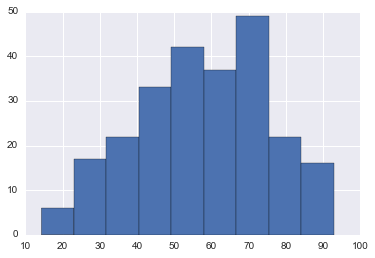

In [8]:
data.extraversion_score.hist(bins=9)

In [9]:
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.kernel_approximation import Nystroem
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Normalizer
from sklearn.svm import LinearSVC

def fit_trait(feature_train, label_train, feature_test, label_test, trait='e'):
    
    bow = CountVectorizer(analyzer=text_process, min_df=.01, )
    tfidf = TfidfTransformer()  
    classifier = get_classifier(trait)
    
    pipeline = make_pipeline(bow, tfidf, classifier)

    pipeline.fit(feature_train, label_train)

    pred = pipeline.predict(feature_test)
    pred_proba = pipeline.predict_proba(feature_test)[:,1]
    
    return pipeline, pred, pred_proba

def get_classifier(trait='e'):
    '''
    Helper function to select the best classifier for a given trait.
    '''
    if trait == 'a':
        classifier = make_pipeline(
            Normalizer(norm="max"),
            Nystroem(gamma=39.0, kernel="poly", n_components=18),
            BernoulliNB(alpha=0.13, binarize=0.48, fit_prior=True))    
    elif trait == 'e':
        classifier = make_pipeline(SelectPercentile(percentile=99, score_func=f_classif),
                                   ExtraTreesClassifier(criterion="entropy",
                                                        max_features=1.0,
                                                        n_estimators=500))
    elif trait == 'o':
        classifier = make_pipeline(Normalizer(norm="max"),
                                   BernoulliNB(alpha=0.86,
                                               binarize=0.2,
                                               fit_prior=True))
    elif trait == 'c':
        classifier = ExtraTreesClassifier(criterion="entropy",
                                          max_features=0.23,
                                          n_estimators=500)

    elif trait == 'n':
        classifier = MultinomialNB(alpha=0.03,
                                   fit_prior=True)
    else:
        classifier = RandomForestClassifier(n_estimators=500)
 
    return classifier

In [10]:
col = data['combined_all']
trait = data['is_extravert']

feature_train_e, feature_test_e, label_train_e, label_test_e = \
train_test_split(col, trait, test_size=0.3)

# Fit the model
pl_e, pred_e, pred_proba_e = fit_trait(feature_train_e, label_train_e,
                                       feature_test_e, label_test_e, trait='e')

# Cross-validate the model
print('Cross_val_score:', cross_val_score(pl_e, col, trait, cv=5).mean())

Cross_val_score: 0.660034013605


## Cumulative Accuracy Profile
I created the following two functions to visualize how well my models are performing.

In [11]:
def results_df(label_test, pred_proba, pred, print_report=True):
    '''
    Compares how well the model is identifying people compared
    to random chance.
    '''
    results = pd.DataFrame()

    results['actual'] = label_test
    results['predicted'] = pred_proba
    
    results.sort_values('predicted', ascending=False, inplace=True)
    
    # Counting positive observations
    results['model_count'] = pd.Series.cumsum(results.actual)
    results['percentage'] = 1/len(results)
    results['random_count'] = pd.Series.cumsum(results['percentage']) * np.sum(results['actual'])
    
    # Percentage of the total found
    results['model_select'] = results['model_count']/np.sum(results['actual'])
    results['random_select'] = pd.Series.cumsum(results.percentage)

    del results['percentage']
    
    if print_report == True:
        print(classification_report(label_test, pred))
    
    return results

In [12]:
results_e = results_df(label_test_e, pred_proba_e, pred_e)

             precision    recall  f1-score   support

          0       0.76      0.49      0.59        39
          1       0.59      0.83      0.69        35

avg / total       0.68      0.65      0.64        74



In [13]:
results_e.head(5)

,actual,predicted,model_count,random_count,model_select,random_select
73,1,0.928,1,0.472973,0.028571,0.013514
210,1,0.888,2,0.945946,0.057143,0.027027
138,1,0.882,3,1.418919,0.085714,0.040541
219,1,0.880,4,1.891892,0.114286,0.054054
122,1,0.868,5,2.364865,0.142857,0.067568


In [14]:
def plot_cap_curve(df):
    plt.plot(df.random_select, df.model_select, color='red')
    plt.plot(df.random_select, df.random_select, color='blue')

    plt.ylabel('Percent found')
    plt.xlabel('Percent selected')

    plt.ylim(0,1)
    plt.xlim(0,1)

    plt.xticks([0, .25, .5, .75, 1])
    plt.yticks([.1, .2, .3, .4,
                .5, .6, .7, .8, .9, 1])

    from pylab import rcParams
    rcParams['figure.figsize'] = 10, 6

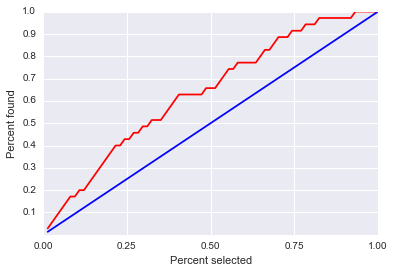

In [15]:
plot_cap_curve(results_e)

My model is finding extraverts much faster than random chance.

Now, let's see what words actually *identify* extraverts.

In [16]:
def word_probabilities(col, pipeline=pl_e, min_df=.01):
    trait_words_dict = {}
    bow_transformer = CountVectorizer(analyzer=text_process, min_df=min_df)
    bow_transformer.fit(col)

    for word, _ in bow_transformer.vocabulary_.items():
        prob = pipeline.predict_proba([word])[0][1]
        trait_words_dict[word] = prob
        
    df = pd.DataFrame([trait_words_dict]).T
    df.columns = ['probability']
    df = df.sort_values('probability', ascending=False)
    
    return df

I don't have a lot of data just yet, so I'm going to re-fit my pipeline with all available data. I don't particularly need a test set anymore.

In [17]:
def trait_pipeline(x, y, trait):
    
    bow = CountVectorizer(analyzer=text_process, min_df=.01, )
    tfidf = TfidfTransformer()
    classifier = get_classifier(trait)
    
    pipeline = make_pipeline(bow, tfidf, classifier)

    pipeline.fit(x,y)
    
    return pipeline

In [18]:
# Replace old pipeline
pl_e = trait_pipeline(data['combined_all'], data['is_extravert'], trait='e')

# Generate word list
extraverted_words = word_probabilities(data['combined_all'], pl_e)

# "Extravert" words up top; "introvert" words at the bottom
extraverted_words

,probability
outgo,0.868
need,0.712
hey,0.696
use,0.638
ever,0.606
danc,0.542
color,0.498
becom,0.486
yet,0.478
travel,0.466


A taste of what's to come: Let's have the model try predicting some text.

In [19]:
def predict_trait(word, pipeline):
    return pipeline.predict_proba([word])[0,1]

# Probability they're extraverted
predict_trait("I'm an outgoing extravert and i like festivals, travel,\
culture, parties, alcohol, singing, and playing the ukulele", pipeline=pl_e)

0.91000000000000003

In [20]:
# Probability they're extraverted
predict_trait("I'm a shy, quiet introvert and i like netflix, pokemon,\
chocolate, and reading books with my cat", pipeline=pl_e)

0.0060000000000000001

# Openness
#### Openness measures intellectual curiosity and creativity.

#### People scoring high in this trait love art and science; they enjoy variety and don’t respect the status quo. Meanwhile, people who score low in openness are more conventional, skeptical, narrow-minded, and old-fashioned.

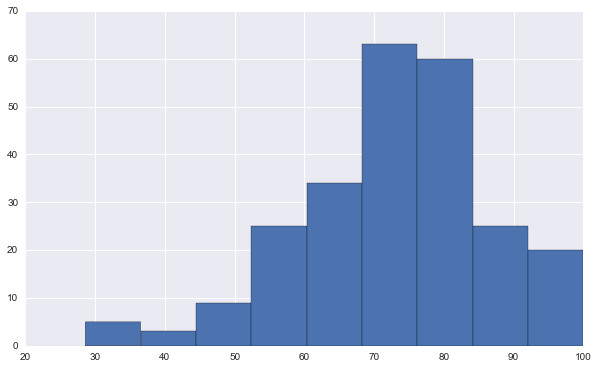

In [21]:
data.openness_score.hist(bins=9)

In [22]:
col = data['combined_all']
trait = data['is_open']

feature_train_o, feature_test_o, label_train_o, label_test_o = \
train_test_split(col, trait, test_size=0.3)

# Fit the model
pl_o, pred_o, pred_proba_o = fit_trait(feature_train_o, label_train_o,
                                       feature_test_o, label_test_o, trait='o')

# Cross-validate the model
print('Cross_val_score:', cross_val_score(pl_o, col, trait, cv=5).mean())

Cross_val_score: 0.56531292517


In [23]:
results_o = results_df(label_test_o, pred_proba_o, pred_o)

results_o.head(10)

             precision    recall  f1-score   support

          0       0.53      0.59      0.56        34
          1       0.61      0.55      0.58        40

avg / total       0.57      0.57      0.57        74



,actual,predicted,model_count,random_count,model_select,random_select
8,1,1.000000,1,0.540541,0.025,0.013514
237,1,0.999987,2,1.081081,0.050,0.027027
191,0,0.999984,2,1.621622,0.050,0.040541
83,1,0.999953,3,2.162162,0.075,0.054054
103,1,0.999946,4,2.702703,0.100,0.067568
89,1,0.999940,5,3.243243,0.125,0.081081
21,1,0.999891,6,3.783784,0.150,0.094595
149,1,0.999346,7,4.324324,0.175,0.108108
208,0,0.999268,7,4.864865,0.175,0.121622
141,1,0.999195,8,5.405405,0.200,0.135135


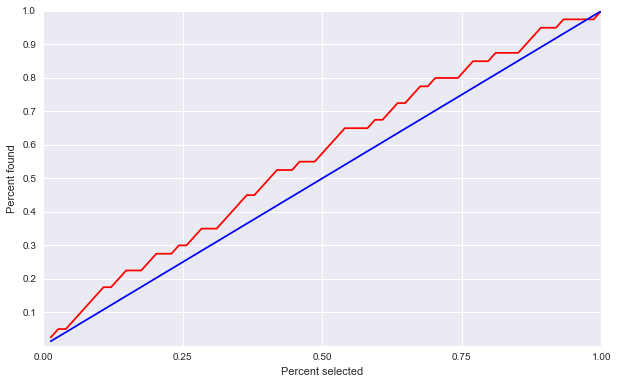

In [24]:
plot_cap_curve(results_o)

In [25]:
# Replace old pipeline
pl_o = trait_pipeline(data['combined_all'], data['is_open'], trait=None)

# Generate word list
open_words = word_probabilities(data['combined_all'], pl_o)

# "Open" and creative words appear at the top
open_words

,probability
thing,0.682
art,0.666
music,0.652
creativ,0.618
think,0.614
lot,0.614
make,0.610
enjoy,0.610
part,0.610
open,0.606


People high in openness tend to mention things like art, music, and meditation. People who score low tend to mention more tangible things like food and family.

I often describe this trait by saying that "open" people are interested in *ideas*, while "closed" people are interested in *facts*.

# Agreeableness
#### This is essentially how “nice” you are.

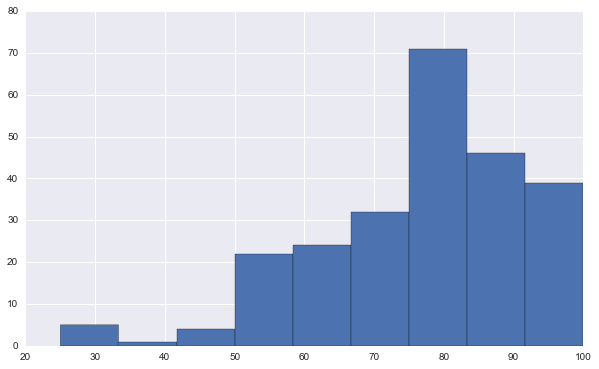

In [49]:
data.agreeableness_score.hist(bins=9)

In [50]:
col = data['combined']
trait = data['is_agreeable']

feature_train_a, feature_test_a, label_train_a, label_test_a = \
train_test_split(col, trait, test_size=0.3)

# Fit the model
pl_a, pred_a, pred_proba_a = fit_trait(feature_train_a, label_train_a,
                                       feature_test_a, label_test_a, trait='a')

# Cross-validate the model
print('Cross_val_score', cross_val_score(pl_a, col, trait, cv=5).mean())

Cross_val_score 0.573724489796


In [51]:
results_a = results_df(label_test_a, pred_proba_a, pred_a)

results_a.head(10)

             precision    recall  f1-score   support

          0       0.55      0.19      0.28        32
          1       0.59      0.88      0.70        42

avg / total       0.57      0.58      0.52        74



,actual,predicted,model_count,random_count,model_select,random_select
79,1,0.789791,1,0.567568,0.023810,0.013514
47,1,0.788896,2,1.135135,0.047619,0.027027
160,0,0.766000,2,1.702703,0.047619,0.040541
2,0,0.763935,2,2.270270,0.047619,0.054054
12,0,0.733323,2,2.837838,0.047619,0.067568
183,0,0.718253,2,3.405405,0.047619,0.081081
83,1,0.718253,3,3.972973,0.071429,0.094595
124,1,0.718253,4,4.540541,0.095238,0.108108
116,1,0.717017,5,5.108108,0.119048,0.121622
43,0,0.717017,5,5.675676,0.119048,0.135135


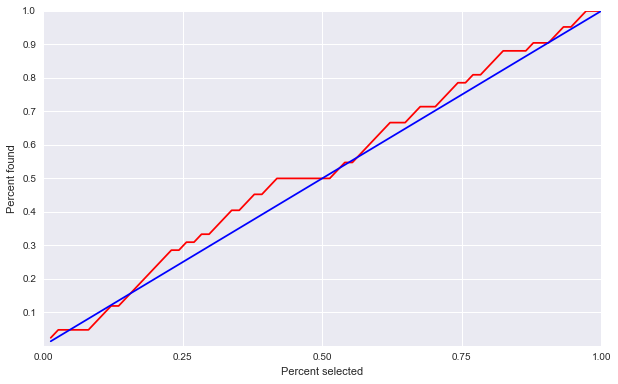

In [52]:
plot_cap_curve(results_a)

This model is currently my weakest; it's only a little better than chance at identifying nice people.

In [53]:
# Replace old pipeline
pl_a = trait_pipeline(data['combined_all'], data['is_agreeable'], trait=None)

# Generate word list
agreeable_words = word_probabilities(data['combined_all'], pl_a)

# "Nice" words up top
agreeable_words

,probability
happi,0.828
everyth,0.808
part,0.806
love,0.800
friend,0.798
way,0.798
good,0.798
young,0.798
littl,0.794
scienc,0.792


The results aren't too surprising: use a lot of positive language; disagreeable people like their phones and cars. :)

# Conscientiousness
#### Conscientiousness measures how organized and responsible you are. Conscientious people are more deliberate in their actions, while people scoring low in conscientiousness tend to be impulsive.

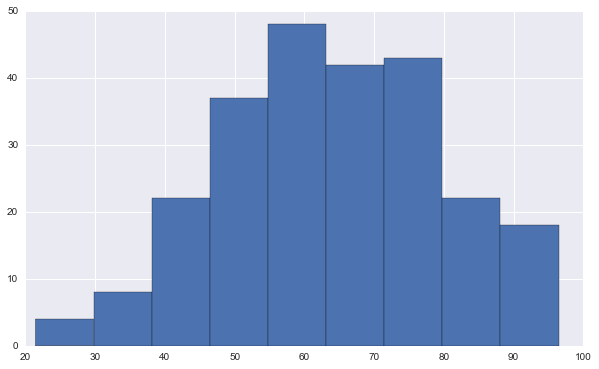

In [54]:
data.conscientiousness_score.hist(bins=9)

In [55]:
col = data['combined_all']
trait = data['is_conscientious']

feature_train_c, feature_test_c, label_train_c, label_test_c = \
train_test_split(col, trait, test_size=0.3)

# Fit the model
pl_c, pred_c, pred_proba_c = fit_trait(feature_train_c, label_train_c,
                                       feature_test_c, label_test_c, trait='c')

# Cross-validate the model
print('Cross_val_score:', cross_val_score(pl_c, col, trait, cv=5).mean())

Cross_val_score: 0.598724489796


In [56]:
results_c = results_df(label_test_c, pred_proba_c, pred_c)

results_c.head(10)

             precision    recall  f1-score   support

          0       0.67      0.46      0.55        39
          1       0.55      0.74      0.63        35

avg / total       0.61      0.59      0.59        74



,actual,predicted,model_count,random_count,model_select,random_select
112,1,0.866,1,0.472973,0.028571,0.013514
96,1,0.850,2,0.945946,0.057143,0.027027
80,1,0.850,3,1.418919,0.085714,0.040541
218,0,0.822,3,1.891892,0.085714,0.054054
184,0,0.790,3,2.364865,0.085714,0.067568
50,0,0.768,3,2.837838,0.085714,0.081081
46,1,0.754,4,3.310811,0.114286,0.094595
44,1,0.748,5,3.783784,0.142857,0.108108
154,0,0.740,5,4.256757,0.142857,0.121622
118,0,0.740,5,4.729730,0.142857,0.135135


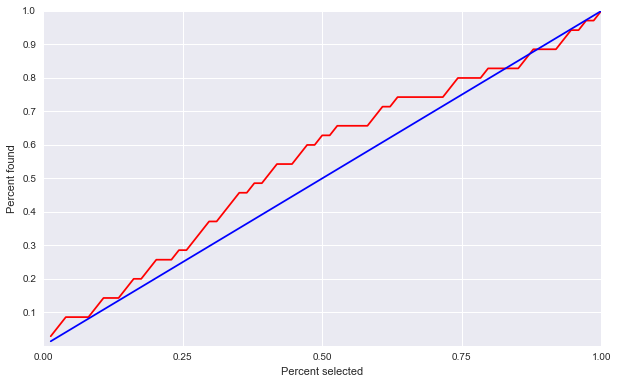

In [57]:
plot_cap_curve(results_c)

In [58]:
# Replace old pipeline
pl_c = trait_pipeline(data['combined_all'], data['is_conscientious'], trait='c')

# Generate word list
conscientious_words = word_probabilities(data['combined_all'], pl_c)

# Conscientious words up top
conscientious_words

,probability
organ,0.842
done,0.708
ride,0.688
program,0.688
success,0.648
middl,0.640
prefer,0.638
natur,0.602
field,0.570
child,0.548


Conscientious people like organic food and getting things done. Un-conscientious people like to sleep, procratinate, and be lazy. The model works!

# Neuroticism
Neuroticism is a measure of how much you tend to worry and/or feel depressed.

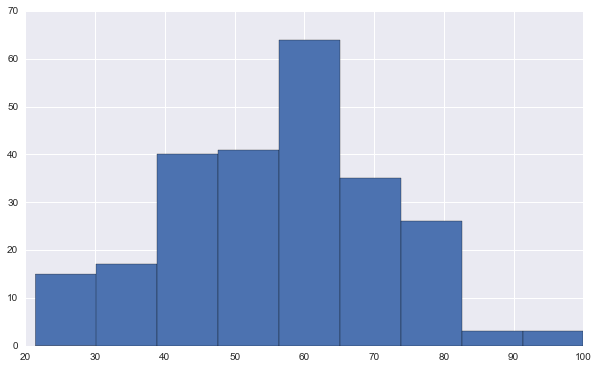

In [71]:
data.neuroticism_score.hist(bins=9)

In [72]:
col = data['combined_all']
trait = data['is_neurotic']

feature_train_n, feature_test_n, label_train_n, label_test_n = \
train_test_split(col, trait, test_size=0.3)

# Fit the model
pl_n, pred_n, pred_proba_n = fit_trait(feature_train_n, label_train_n,
                                       feature_test_n, label_test_n, trait='n')

# Cross-validate the model
print('Cross_val_score:', cross_val_score(pl_n, col, trait, cv=5).mean())

Cross_val_score: 0.581391156463


In [73]:
results_n = results_df(label_test_n, pred_proba_n, pred_n)

results_n.head(10)

             precision    recall  f1-score   support

          0       0.55      0.53      0.54        34
          1       0.61      0.62      0.62        40

avg / total       0.58      0.58      0.58        74



,actual,predicted,model_count,random_count,model_select,random_select
7,1,0.960468,1,0.540541,0.025,0.013514
124,1,0.943178,2,1.081081,0.050,0.027027
85,1,0.923867,3,1.621622,0.075,0.040541
100,1,0.915770,4,2.162162,0.100,0.054054
162,0,0.879511,4,2.702703,0.100,0.067568
34,1,0.859912,5,3.243243,0.125,0.081081
170,1,0.846197,6,3.783784,0.150,0.094595
51,1,0.837916,7,4.324324,0.175,0.108108
36,1,0.832073,8,4.864865,0.200,0.121622
135,1,0.830583,9,5.405405,0.225,0.135135


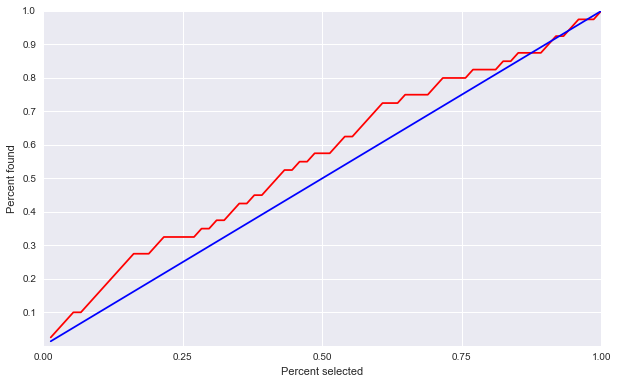

In [74]:
plot_cap_curve(results_n)

In [75]:
# Replace old pipeline
pl_n = trait_pipeline(data['combined_all'], data['is_neurotic'], trait='n')

# Generate word list
neurotic_words = word_probabilities(data['combined_all'], pl_n)

# Neurotic words up top
neurotic_words

,probability
may,0.976494
memori,0.970237
earth,0.966474
k,0.963699
sock,0.961873
minor,0.960602
theatr,0.959884
overthink,0.957686
softbal,0.956971
depress,0.956694


Except for words like "overthink," the results aren't very intuitive. I think I still need some more data for this trait.

# Summary
#### How do my models perform?

In [76]:
# Update the pipelines one last time and make them congruent
pl_e = trait_pipeline(data['combined_all'], data['is_extravert'], trait='e')
pl_o = trait_pipeline(data['combined_all'], data['is_open'], trait='o')
pl_a = trait_pipeline(data['combined_all'], data['is_agreeable'], trait='a')
pl_c = trait_pipeline(data['combined_all'], data['is_conscientious'], trait='c')
pl_n = trait_pipeline(data['combined_all'], data['is_neurotic'], trait='n')

In [77]:
print('Extraversion:',cross_val_score(pl_e, col, data['is_extravert'], cv=5).mean())
print('Openness:', cross_val_score(pl_o, col, data['is_open'], cv=5).mean())
print('Conscientiousness:', cross_val_score(pl_c, col, data['is_conscientious'], cv=5).mean())
print('Neuroticism:', cross_val_score(pl_n, col, data['is_neurotic'], cv=5).mean())
print('Agreeableness:', cross_val_score(pl_a, col, data['is_agreeable'], cv=5).mean())

Extraversion: 0.655782312925
Openness: 0.56531292517
Conscientiousness: 0.574149659864
Neuroticism: 0.581391156463
Agreeableness: 0.565391156463


# Myers-Briggs Predictor

Myers-Briggs Type Indicator (MBTI) is not actually used by psychologists, but many people are familiar with it. It assigns you a 4-letter (and sometimes 5-letter) code to summarize your personality traits:

#### Letter 1
- E: Extraverted
- I: Introverted

#### Letter 2
- N: Intuitive (similar to high in openness)
- S: Sensing (low openness)

#### Letter 3
- F: Feeling (similar to high agreeableness)
- T: Thinking (low agreeableness)

#### Letter 4
- J: Judging (similar to high conscientiousness
- P: Perceiving (low conscientiousness)

#### Letter 5
- T: Turbulent (similar to high neuroticism)
- A: Assertive (low neuroticism)

(You can learn more [here](https://www.16personalities.com/articles/our-theory).)

...wouldn't it be cool to predict your MBTI based on the text you use? I'm going to attempt it below!

In [87]:
def personality_analyzer(text):
    e = predict_trait(text, pipeline=pl_e)
    o = predict_trait(text, pipeline=pl_o)
    a = predict_trait(text, pipeline=pl_a)
    c = predict_trait(text, pipeline=pl_c)
    n = predict_trait(text, pipeline=pl_n)
    
    print('Extraversion: %.2f' % e)
    print('Openness: %.2f' % o)
    print('Agreeableness: %.2f' % a)
    print('Conscientiousness: %.2f' % c)
    print('Neuroticism: %.2f' % n)
    print()
    print('This person appears to be a:')
    
    # Still tuning these numbers...
    if e > .45:
        print('E', end='')
    elif e <= .45:
        print('I', end='')
    if o > .56:
        print('N', end='')
    elif o <= .56:
        print('S', end='')
    if a > .42:
        print('F', end='')
    elif a <= .42:
        print('T', end='')
    if c > .42:
        print('J', end='')
    elif c <= .42:
        print('P', end='')
    print('-', end='')
    if n > .33:
        print('T', end='')
    elif n <= .33:
        print('A', end='')    

In [88]:
me = '''
I'm insatiably curious. That's probably my most defining characteristic, with enthusiasm
being a close 2nd.

I'm a psychology professor and data scientist. Creativity is an important part of my life.

For fun I like to perform improv and play with my dog. I spend a lot of time around computers,
so I also love to go out and enjoy nature whenever I get the chance.
'''

personality_analyzer(me)

Extraversion: 0.53
Openness: 0.59
Agreeableness: 0.39
Conscientiousness: 0.62
Neuroticism: 0.30

This person appears to be a:
ENTJ-A

Not bad! But I'm cheating a little. I tuned the parameters so it would properly identify me as an ENFJ/ENTJ.

How about someone with a similar personality to mine?

In [89]:
obama = '''
And you know, what struck me when I first met Barack was that even though he had this
funny name, even though he'd grown up all the way across the continent in Hawaii, his
family was so much like mine. He was raised by grandparents who were working-class folks
just like my parents, and by a single mother who struggled to pay the bills just like
we did. Like my family, they scrimped and saved so that he could have opportunities
they never had themselves. And Barack and I were raised with so many of the same values:
that you work hard for what you want in life; that your word is your bond and you do what
you say you're going to do; that you treat people with dignity and respect, even if you
don't know them, and even if you don't agree with them.

And Barack and I set out to build lives guided by these values, and pass them on to the
next generation. Because we want our children — and all children in this nation — to
know that the only limit to the height of your achievements is the reach of your dreams
and your willingness to work for them.'''
# (Michelle describing Barack)

personality_analyzer(obama)

Extraversion: 0.46
Openness: 0.07
Agreeableness: 0.44
Conscientiousness: 0.43
Neuroticism: 0.17

This person appears to be a:
ESFJ-A

This is actually pretty close!

I don't know for certain what Barack Obama's MBTI is, but I'd guess it's either ENFJ or ENTJ.

How artistic you are is a big part of openness (N vs. S for your 2nd letter), but it's not the *only* part.

He's always struck me as a visionary and someone who's intellectually curious. But none of that is addressed in Michelle Obama's speech.

Finally, someone whom I'm definitely *not*...

In [90]:
bond = '''
The Bond character is a Secret Service agent, code number 007, residing in London but active
internationally. Bond was a composite character who was based on a number of commandos whom Fleming
knew during his service in the Naval Intelligence Division during World War II, to whom Fleming added
his own style and a number of his own tastes. Bond has a number of character traits which run throughout
the books, including an enjoyment of cars, a love of food and drink, and an average intake of sixty
custom-made cigarettes a day.
'''

personality_analyzer(bond)

Extraversion: 0.41
Openness: 0.01
Agreeableness: 0.06
Conscientiousness: 0.51
Neuroticism: 0.15

This person appears to be a:
ISTJ-A

*Almost* nailed it! I'd type James Bond as an ISTP-A, but ISTJ-A is pretty darn close.

# Final verdict
This is a fun project and is showing some promise! For a lot of machine learning tasks, a 60% accuracy rate wouldn't be particularly good. Nonetheless, I'm impressed by the model's ability to predict someone's personality traits just based on the words they used. All things considered, 60% accuracy is pretty impressive for such ambiguous data.

I have a nagging concern that the small sample size might be a problem, but my cross-validation methods have reduced the probability of overfitting the data.

If I continue working on this project, I'd first gather more data, then make my models more conservative to further reduce the possiblity of overfitting.